# Análisis de los retornos anuales del índice NASDAQ (IXIC) mediante Gráficos de Control Estacionario de Shewhart y comparativa con el S&P 500

## Autor: Sergio Boatella

Se presenta a continuación, un análisis de las tasas de retorno del índice NASDAQ (IXIC) desde 1971 hasta la actualidad, utilizando un Gráfico de Control Estacionario de Shewhart. 

- Análisis del NASDAQ:
    1. Gráfico de Control Estacionario
    2. Identificación de causas especiales
    3. Comportamiento en períodos de crisis
- Comparativa: Análisis similar sobre el S&P500 en el mismo periodo
    1. Gráfico de Control Estacionario
    2. Identificación de causas especiales
    3. Comportamiento en períodos de crisis
- Respuesta a las preguntas planteadas en la tarea.


NOTA: _Se presenta este trabajo en forma de Jupyter Notebook con el objetivo de aportar los conocimientos previos personales del autor, y así aprovechar el potencial de otras herramientas distintas de Excel_



In [1]:
from IPython.display import Markdown as md
from IPython.display import display_markdown
import pandas as pd
import requests as req
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Gráfico de Control Estacionario

## Resultado

Media : 9.05<br>    Sigma : 19.16<br>

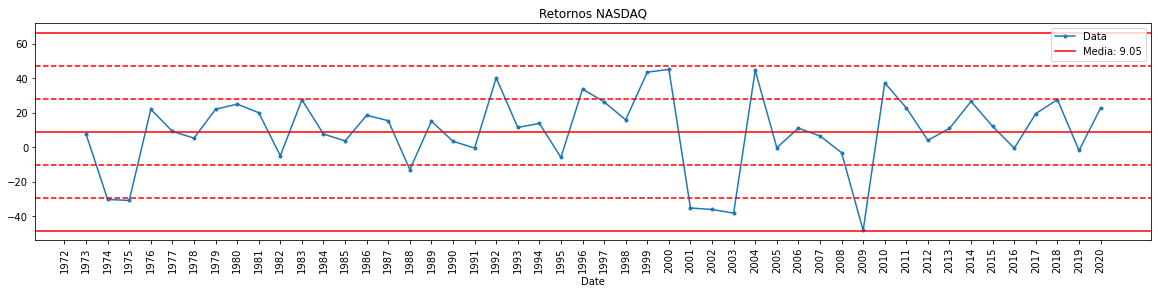

In [2]:

# Download data from Yahoo Finance from 01/01/1971 until current time.
timestamp = int(datetime.timestamp(datetime.now()))
download_url = "https://query1.finance.yahoo.com/v7/finance/download/%5EIXIC?period1=34560000&period2={}&interval=1mo&events=history".format(timestamp)

r = req.get(download_url, allow_redirects=True)
open('historical_data.csv', 'wb').write(r.content)

# Data conversion to Pandas dataframe
historical_data = pd.read_csv("historical_data.csv")
historical_data = historical_data[pd.to_datetime(historical_data['Date']).dt.month == 1]
historical_data.set_index('Date', inplace=True)

# Return, Moving-Range, Average, and Sigma calcuation
adj_close_year = historical_data['Adj Close']
rt = 100 * np.log(adj_close_year / adj_close_year.shift(1))
rm = np.abs(rt - rt.shift(1))

average_rt = rt.mean()
average_rm = rm.mean()
sigma = 2.66 * average_rm / 3 
regions = np.arange(3,-4,-1) * sigma + average_rt

# Plotting the chart
def fullplot(indata, inregions):
    plt.rcParams['figure.figsize'] = [20, 4]

    xticks = np.array(pd.to_datetime(indata.index).year.to_list())

    my_plot = indata.plot(style='.-', label="Data")
    plt.xticks(np.arange(indata.shape[0])[::1], xticks[::1], rotation=90)

    plt.axhline(y=inregions[0], color='r', linestyle='-')
    plt.axhline(y=inregions[1], color='r', linestyle='--')
    plt.axhline(y=inregions[2], color='r', linestyle='--')
    plt.axhline(y=inregions[3], color='r', linestyle='-', label="Media: " + str(round(inregions[3],2)))
    plt.axhline(y=inregions[4], color='r', linestyle='--')
    plt.axhline(y=inregions[5], color='r', linestyle='--')
    plt.axhline(y=inregions[6], color='r', linestyle='-')
    plt.legend(loc='upper right')

    return my_plot, xticks

mplt, xticks = fullplot(rt, regions)
mplt.set_title("Retornos NASDAQ")

display_markdown(md("## Resultado"))
md("Media : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_rt, sigma))

## Identificación de Causas Especiales

Sobre esta misma gráfica, se procede a identificar los periodos afectados por causas especiales, y se resaltarán en verde en la siguiente figura:

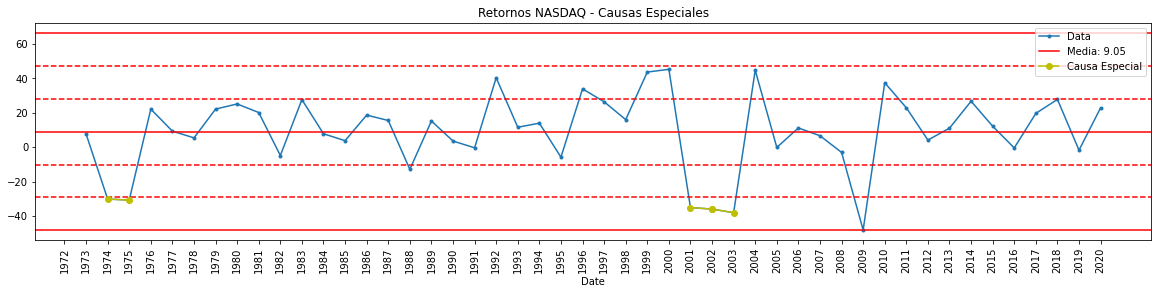

In [3]:
def find_condition(data, window_size, condition, min_number=None):
    _min_number = window_size if min_number is None else min_number
    finds = []
    for i in range(len(data) - window_size + 1):
        if i in finds:
            pass

        count = sum(map(condition, data[i:i+window_size]))        
        if count >= _min_number:
            finds.append(list(range(i, i+window_size)))
    return finds

def strictly_increasing(L):
    return all(x <= y for x, y in zip(L, L[1:]))

def strictly_decreasing(L):
    return all(x >= y for x, y in zip(L, L[1:]))

def trend(L):
    return strictly_decreasing(L) or strictly_increasing(L)

def find_trend(data, window_size):    
    finds = []
    for i in range(len(data) - window_size + 1):   
        if i in finds:
            pass        
        if trend(data[i:i+window_size]):
            finds.append(list(range(i, i+window_size)))
    return finds

def wave(L):    
    even = L[0] > L[1]
    for x, y in zip(L, L[1:]):
        if even:
            if x < y:
                return False
        else:
            if x > y:
                return False    
        even = not even
    return True

def find_wave(data, window_size):    
    finds = []
    for i in range(len(data) - window_size + 1):     
        if i in finds:
            pass      
        if wave(data[i:i+window_size]):
            finds.append(list(range(i, i+window_size)))
    return finds

def signals(indata, verbose=False, iterative=False):
    signals = []
    _data = indata.copy()
    # 1) Outside limits
    signal_1 = find_condition(_data, 1, lambda x: x >= regions[0]  or regions[6] >= x)
    if verbose: print("Signal 1: ", signal_1)
    for s in signal_1:
        signals.append(s)     
        _data[s] = None

    # 2) 2 points in region A
    signal_2 = find_condition(_data, 2, lambda x:  regions[0] >= x >= regions[1]  or regions[5] >= x >= regions[6] , 2)
    if verbose: print("Signal 2: ", signal_2)
    for s in signal_2:
        signals.append(s)  
        _data[s] = None   

    # 3) 4 points in region A and/or B
    signal_3 = find_condition(_data, 4, lambda x: regions[0] >= x >= regions[2]  or regions[4] >= x >= regions[6], 4)
    if verbose: print("Signal 3: ", signal_3)
    for s in signal_3:
        signals.append(s)    
        _data[s] = None    

    # 4) 9 consecutive points on one side of central axis
    signal_4 = find_condition(_data, 9, lambda x: x > regions[3] ) + find_condition(rt, 9, lambda x: x < regions[3])
    if verbose: print("Signal 4: ", signal_4)
    for s in signal_4:
        signals.append(s) 
        _data[s] = None   

    # 5) 6 consecutive points increasing/decreasing only
    signal_5 = find_trend(_data, 6)
    if verbose: print("Signal 5: ", signal_5)
    for s in signal_5:
        signals.append(s) 
        _data[s] = None   

    # 6) 14 consecutive points in oscilation
    signal_6 = find_wave(_data, 14)
    if verbose: print("Signal 6: ", signal_6)
    for s in signal_6:
        signals.append(s) 
        _data[s] = None   

    # 7) 15 consecutive points in region C
    signal_7 = find_condition(_data, 15, lambda x: regions[2] > x > regions[4] )
    if verbose: print("Signal 7: ", signal_7)
    for s in signal_7:
        signals.append(s) 
        _data[s] = None   
    
    return signals

mplt, xticks = fullplot(rt, regions)
mplt.set_title("Retornos NASDAQ - Causas Especiales")

first = True
for signal in signals(rt):    
    if first:
        mplt.plot(signal, rt[signal], '-o',color='y', label='Causa Especial')
        mplt.legend(loc='upper right')
        first = False
    else:
        mplt.plot(signal, rt[signal], '-o',color='y')
    


Así pues, se observa que los periodos afectados por causas especiales son:

-  1974-1975
-  1999-2004

Se procede ahora a realizar el cálculo del gráfico de control estacionario, pero esta vez eliminando de los datos estos periodos señalados. El gráfico se reajusta cada vez que se identifica una causa especial.

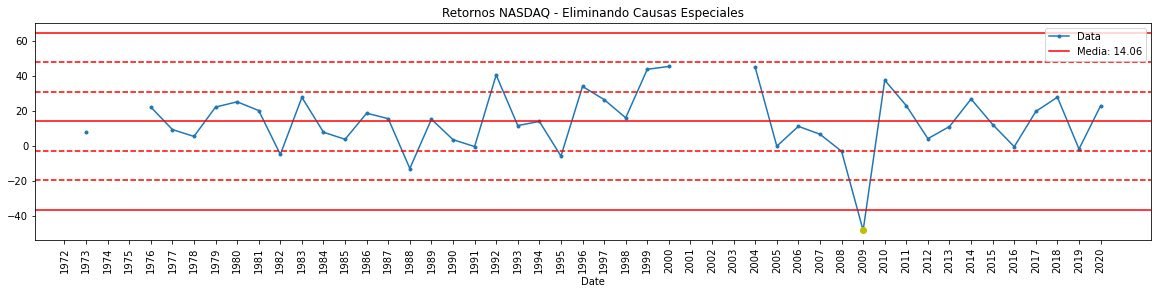

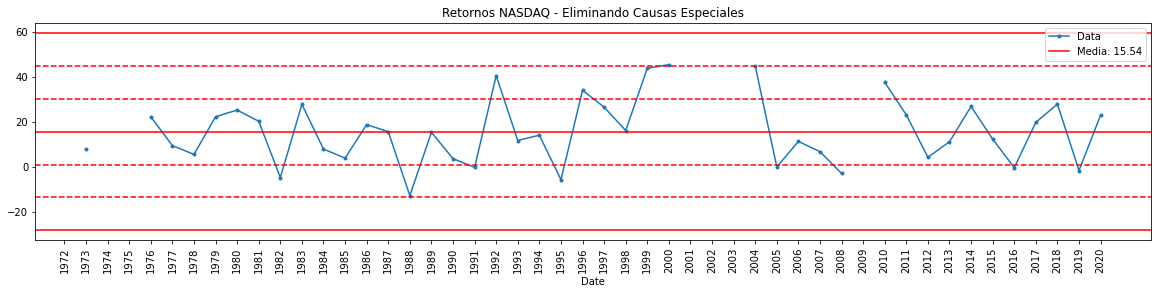

In [4]:
special_signal = True

special_cause = []

tmp_rt = rt.copy()
tmp_rm = rm.copy()

count = 0
while special_signal:
    all_signal = set([])
    for signal in signals(tmp_rt):
        all_signal.update(set(signal))

    dropable = sorted(list(all_signal))

    for d in dropable:
        special_cause.append(d)
        tmp_rt[d] = None
        tmp_rm[d] = None
        if len(tmp_rm) > d + 1: 
            tmp_rm[d+1] = None

    average_rt = tmp_rt.mean()
    average_rm = tmp_rm.mean()
    sigma = 2.66 * average_rm / 3
    regions = np.arange(3,-4,-1) * sigma + average_rt

    figure, axes = plt.subplots(1, 1)
    mplt, xticks = fullplot(tmp_rt, regions)
    mplt.set_title("Retornos NASDAQ - Eliminando Causas Especiales")

    special_signal = False   
    for signal in signals(tmp_rt):
        mplt.plot(signal, tmp_rt[signal], '-o',color='y')
        special_signal = True

    count += 1
    if(count == 10): break

De esta manera, al reajustar los valores de la estimación de la media y de sigma, se identifica una nueva causa especial en 2009.

Si eliminamos esta causa especial nuevamente, los valores son:

In [5]:
num_points = sum(map(lambda x: not pd.isna(x), tmp_rt)) 
num_points_sigma1 = sum(map(lambda x: regions[2] > x > regions[4], tmp_rt))       

display_markdown(md("## Resultado"))
md("Media : {:0.2f}<br>\
    Sigma : {:0.2f}<br>\
    Ratio de puntos en +-1 Sigma : {:0.2f}<br>".format(average_rt, sigma, num_points_sigma1/num_points))

## Resultado

Media : 15.54<br>    Sigma : 14.64<br>    Ratio de puntos en +-1 Sigma : 0.67<br>

## Comportamiento en períodos de crisis

Se aíslan los datos pertenecientes a los periodos afectados por causas especiales, y se toman aquellos que tienen un valor negativo para hacer un cálculo similar.

Text(0.5, 1.0, 'Retornos NASDAQ - Período Crisis')

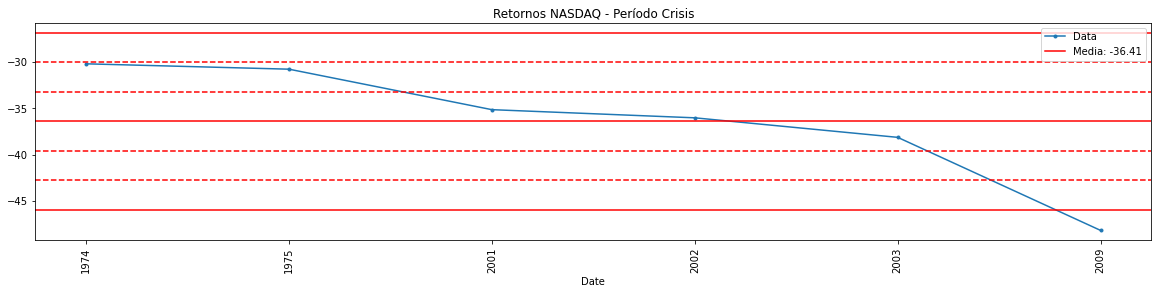

In [6]:
_sc = rt[sorted(special_cause)]
sc = _sc[_sc < 0]

rm_sc = np.abs(sc - sc.shift(1))

average_sc = sc.mean()
average_rm_sc = rm_sc.mean()
sigma_sc = 2.66 * average_rm_sc / 3 
regions_sc = np.arange(3,-4,-1) * sigma_sc + average_sc

figure, axes = plt.subplots(1, 1)
mplt, xticks = fullplot(sc, regions_sc)

mplt.set_title("Retornos NASDAQ - Período Crisis")

In [7]:
display_markdown(md("## Resultado"))
md("Media : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_sc, sigma_sc))

## Resultado

Media : -36.41<br>    Sigma : 3.18<br>

## Comparativa: Análisis similar sobre el S&P500 en el mismo periodo


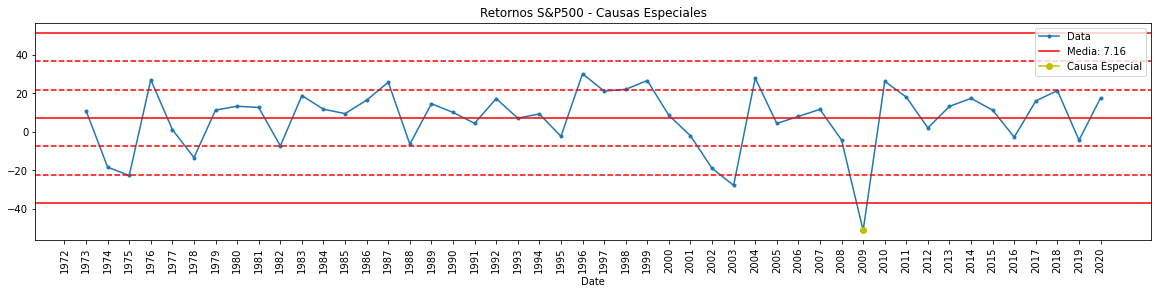

In [8]:
# Download data from Yahoo Finance from 01/01/1971 until current time.
download_url = "https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=34560000&period2={}&interval=1mo&events=history".format(timestamp)

r = req.get(download_url, allow_redirects=True)
open('historical_data.csv', 'wb').write(r.content)

# Data conversion to Pandas dataframe
historical_data = pd.read_csv("historical_data.csv")
historical_data = historical_data[pd.to_datetime(historical_data['Date']).dt.month == 1]
historical_data.set_index('Date', inplace=True)

# Return, Moving-Range, Average, and Sigma calcuation
adj_close_year = historical_data['Adj Close']
rt = 100 * np.log(adj_close_year / adj_close_year.shift(1))
rm = np.abs(rt - rt.shift(1))

average_rt = rt.mean()
average_rm = rm.mean()
sigma = 2.66 * average_rm / 3 
regions = np.arange(3,-4,-1) * sigma + average_rt

mplt, xticks = fullplot(rt, regions)
mplt.set_title("Retornos S&P500 - Causas Especiales")

first = True
for signal in signals(rt):    
    if first:
        mplt.plot(signal, rt[signal], '-o',color='y', label='Causa Especial')
        mplt.legend(loc='upper right')
        first = False
    else:
        mplt.plot(signal, rt[signal], '-o',color='y')



In [9]:
display_markdown(md("## Resultado"))
md("Media : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_sc, sigma_sc))

## Resultado

Media : -36.41<br>    Sigma : 3.18<br>

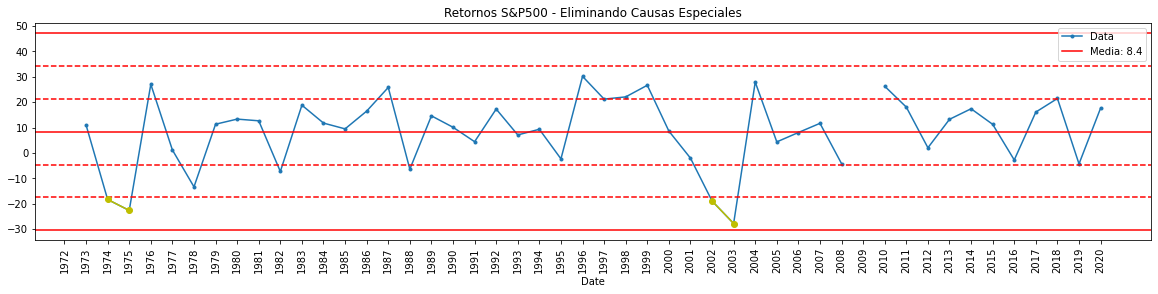

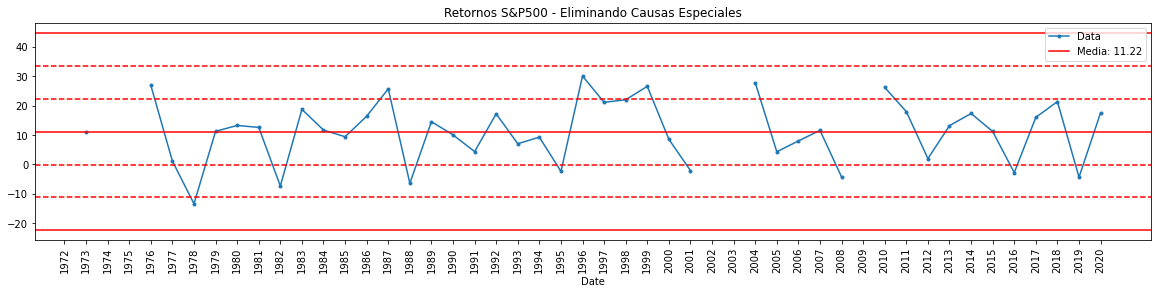

In [10]:
special_signal = True

special_cause = []

tmp_rt = rt.copy()
tmp_rm = rm.copy()

count = 0
while special_signal:
    all_signal = set([])
    for signal in signals(tmp_rt):
        all_signal.update(set(signal))

    dropable = sorted(list(all_signal))

    for d in dropable:
        special_cause.append(d)
        tmp_rt[d] = None
        tmp_rm[d] = None
        if len(tmp_rm) > d + 1: 
            tmp_rm[d+1] = None

    average_rt = tmp_rt.mean()
    average_rm = tmp_rm.mean()
    sigma = 2.66 * average_rm / 3
    regions = np.arange(3,-4,-1) * sigma + average_rt

    figure, axes = plt.subplots(1, 1)
    mplt, xticks = fullplot(tmp_rt, regions)
    mplt.set_title("Retornos S&P500 - Eliminando Causas Especiales")

    special_signal = False   
    for signal in signals(tmp_rt):
        mplt.plot(signal, tmp_rt[signal], '-o',color='y')
        special_signal = True

    count += 1
    if(count == 10): break



De igual modo que en el caso anterior, el gráfico se reajusta cada vez que se identifica una causa especial.

In [11]:
display_markdown(md("## Resultado"))
md("Media : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_rt, sigma))

## Resultado

Media : 11.22<br>    Sigma : 11.23<br>

Text(0.5, 1.0, 'Retornos S&P500 - Período Crisis')

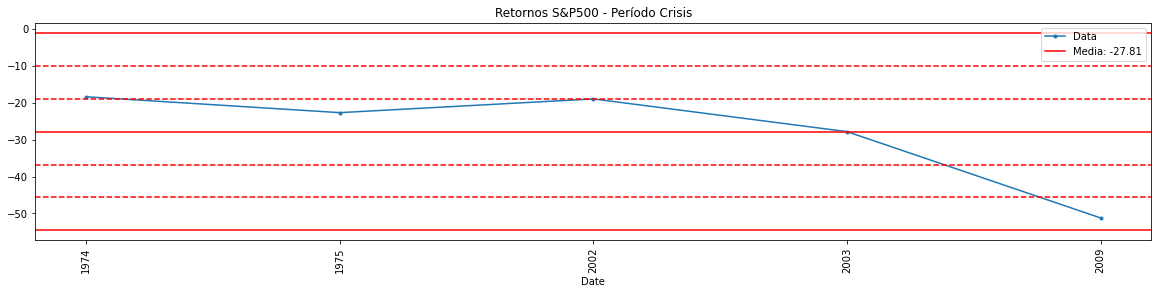

In [12]:
_sc = rt[sorted(special_cause)]
sc = _sc[_sc < 0]

rm_sc = np.abs(sc - sc.shift(1))

average_sc = sc.mean()
average_rm_sc = rm_sc.mean()
sigma_sc = 2.66 * average_rm_sc / 3 
regions_sc = np.arange(3,-4,-1) * sigma_sc + average_sc

figure, axes = plt.subplots(1, 1)
mplt, xticks = fullplot(sc, regions_sc)

mplt.set_title("Retornos S&P500 - Período Crisis")

In [13]:
display_markdown(md("## Resultado"))
md("Media : {:0.2f}<br>\
    Sigma : {:0.2f}<br>".format(average_sc, sigma_sc))

## Resultado

Media : -27.81<br>    Sigma : 8.94<br>

## Respuesta a las preguntas planteadas en la tarea

### ¿Cuánto es el valor no condicionado esperado (media) para dicha variable? A nivel ejecutivo, ¿cómo se interpreta dicho valor?

El retorno esperado (media) del NASDAQ en ausencia de causas especiales es de 15.54. 

### ¿Cuánto es la variación máxima y mínima esperada bajo el supuesto de estabilidaden el data-generating-process?

En ausencia de crisis (~90% del tiempo):

- En un 68%: \[4, 26\]
- En un 95%: \[-7, 38\]
- En un 99.7%: \[-18, 49\]

### ¿Es estable la conducta su variable? ¿Cómo lo sabe?

Sí, porque se trata de una distribución aleatoria acampanada en torno a una media, en la que, en ausencia de causas especiales, el 67% valores de retorno se encuentran dentro de los límites +-1 Sigma, y no se encuentra ningún valor entre +-3 Sigma (aunque podría darse el caso, con una probabilidad de 3 entre 1000).

### ¿Hay causas especiales de variación? ¿Puede atribuirle las causas a algún factor del entorno económico o financiero? ¿Cambió usted algo? Si necesario investigue noticias y qué pudo haber ocurrido en las fechas donde parecieran haber causas especiales de variación.

Se observa que los periodos afectados por causas especiales son:

-  1974-1975, que se relaciona con la crisis del petróleo de 1973.
-  1999-2004, que se relaciona con la burbuja de las Dot-com entre 1997 y 2000.
-  2009, que se relaciona con la crisis financiera de 2008.

### Haga un pronóstico de su variable para los siguientes dos periodos.

Si se tienen en cuenta los siguientes valores:
- Probabilidad de crisis del 12.5%
- Retorno esperado en ausencia de crisis: 15.5
- Retorno esperado en periodo de crisis: -36.4






In [14]:
pronostico = 0.875 * 15.5 + 0.125 * -36.41
md("Pronostico del valor de retorno del NASDAQ : {:0.1f}<br>".format(pronostico))


Pronostico del valor de retorno del NASDAQ : 9.0<br>

### Comente qué aspectos aprendió sobre su variable de interés, producto de su anális

Se puede observar que el comportamiento del NASDAQ es similar al S&P500 en cuanto a que se ve afectado por las mismas causas especiales, y que en los periodos en los que no hay crisis, se comporta como un mercado eficiente. 

No obstante, parece que los valores de retorno del NASDAQ son algo superiores, ya que tienen una media del 15% frente al 11% del S&P500. Por otro lado, las crisis afectan de manera más pronunciada, puesto que en el NASDAQ tienen una media del -36% frente al -27% del S&P500, siendo la probabilidad de crisis similar.

En cuanto a los periodos de crisis, no parece que se trate de una variable estacionaria, si no más bien una pendiente creciente, pero la muestra es tan pequeña que lo más probable es que esté ocasionada por la propia aleatoriedad del proceso.